In [14]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict

import scipy.stats as scs
import cassiopeia.TreeSolver.compute_meta_purity as cmp
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

from scipy.linalg import eig 
import matplotlib

import utilities.compute_transition_probs as ctp

from contextlib import suppress


## Read in lineage groups

In [15]:
lg_meta = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/home/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
for tree_dir in os.listdir(home_dir):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    if len(fps) > 0:
        try:
            tree = nx.read_gpickle(tree_dir + fps[0])
            lg_to_tree[int(lg)] = tree
        except:
            print(lg)
            continue

## Form transition matrices

In [16]:
consensus_mat = ctp.build_consensus_transition_mat([tree.get_network() for tree in lg_to_tree.values()], lg_meta, 'sampleID', iterations=200)

100%|██████████| 99/99 [1:20:07<00:00, 48.56s/it]


In [17]:
consensus_mat.to_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t')
# consensus_mat = pd.read_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t', index_col = 0)

In [18]:
bg_dir = '/home/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/'
weights = {}

lgs = lg_to_tree.values()
total_size = np.sum([len(lg.network.nodes()) for lg in lgs])
num_lgs = len(lgs)
num_meta = len(lg_meta['sampleID'].unique())

for n in lg_to_tree.keys():
    weights[n] = len(lg_to_tree[n].network.nodes()) / total_size
    
bg_consensus = np.zeros((num_meta, num_meta))

for bgfp in os.listdir(bg_dir):
    
    bg = pd.read_csv(bg_dir + bgfp, sep='\t', index_col = 0)
    lg = bgfp.split("_")[0][2:]
    
    bg_consensus += bg * (weights[int(lg)] / num_lgs)

    labels = bg_consensus.columns
    bg_consensus = bg_consensus.values
    np.fill_diagonal(bg_consensus, np.nan)

    bg_consensus = pd.DataFrame(bg_consensus, index=labels, columns=labels)


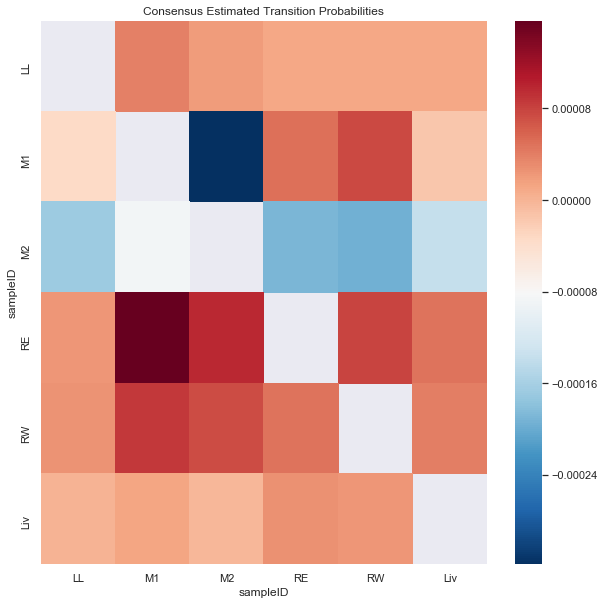

In [21]:
res = consensus_mat.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg_consensus.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")

plt.savefig('consensus_transition_matrix.NORMALIZED.pdf')